In [17]:
from load_blender import load_blender_data
basedir = r'./logs'
datadir = r'./data/nerf_synthetic/lego'
dataset_type = 'blender'

no_batching = True

use_viewdirs = True
white_bkgd = True
lrate_decay = 500

N_samples = 64
N_importance = 128
N_rand = 1024

precrop_iters = 500
precrop_frac = 0.5

half_res = True
testskip = 8

images, poses, render_poses, hwf, i_split = load_blender_data(datadir, half_res, testskip)
print('images shape: ', images.shape)
print('poses shape: ', poses.shape)
print(poses[0])
print('i_split: train val test')
print('hwf: ', hwf)
print('render poses: ', render_poses.shape)
print('c2w: ', render_poses[0].shape)

images shape:  (138, 400, 400, 4)
poses shape:  (138, 4, 4)
[[-9.9990219e-01  4.1922452e-03 -1.3345719e-02 -5.3798322e-02]
 [-1.3988681e-02 -2.9965907e-01  9.5394367e-01  3.8454704e+00]
 [-4.6566129e-10  9.5403719e-01  2.9968831e-01  1.2080823e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]
i_split: train val test
hwf:  [400, 400, 555.5555155968841]
render poses:  torch.Size([40, 4, 4])
c2w:  torch.Size([4, 4])
tensor([[ 1.0000e+00,  6.1232e-17, -1.0606e-16, -4.2423e-16],
        [-1.2246e-16,  5.0000e-01, -8.6603e-01, -3.4641e+00],
        [ 0.0000e+00,  8.6603e-01,  5.0000e-01,  2.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])


In [34]:
import torch
import numpy as np
# c2w rays_o rays_d
H = 400
W = 400
focal = 555.5555155968841
c2w = torch.as_tensor([[1.0000e+00,  6.1232e-17, -1.0606e-16, -4.2423e-16],
        [-1.2246e-16,  5.0000e-01, -8.6603e-01, -3.4641e+00],
        [ 0.0000e+00,  8.6603e-01,  5.0000e-01,  2.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])

i, j = torch.meshgrid(torch.linspace(0, W-1, W), torch.linspace(0, H-1, H))
i = i.t()
j = j.t()
K = np.array([
            [focal, 0, 0.5*W],
            [0, focal, 0.5*H],
            [0, 0, 1]
        ])
# K * (x, y, z).T
# x * fx / z + 0.5 * W
# y * fy / z + 0.5 * H

# dirs:
# x0 = 0.5 * W, y0 = 0.5 * H
# ((i - x0) / fx, (j - y0) / fy, -1).T

dirs = torch.stack([(i-K[0][2])/K[0][0], -(j-K[1][2])/K[1][1], -torch.ones_like(i)], -1)
print(dirs.shape)
print(dirs[0, 0])
# # Rotate ray directions from camera frame to the world frame
rays_d = torch.sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)  # dot product, equals to: [c2w.dot(dir) for dir in dirs]
# # Translate camera frame's origin to the world frame. It is the origin of all rays.
rays_o = c2w[:3,-1].expand(rays_d.shape)

print(rays_d.shape)
print(rays_o.shape)

torch.Size([400, 400, 3])
tensor([-0.3600,  0.3600, -1.0000])
torch.Size([400, 400, 3])
torch.Size([400, 400, 3])


In [44]:
H = 400
W = 400
focal = 555.5555155968841
c2w = torch.as_tensor([[1.0000e+00,  6.1232e-17, -1.0606e-16, -4.2423e-16],
        [-1.2246e-16,  5.0000e-01, -8.6603e-01, -3.4641e+00],
        [ 0.0000e+00,  8.6603e-01,  5.0000e-01,  2.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])
i, j = torch.meshgrid(torch.linspace(0, W-1, W), torch.linspace(0, H-1, H))
i = i.t()
j = j.t()
K = np.array([
            [focal, 0, 0.5*W],
            [0, focal, 0.5*H],
            [0, 0, 1]
        ])
dirs = torch.stack([(i-K[0][2])/K[0][0], -(j-K[1][2])/K[1][1], -torch.ones_like(i)], -1)
rays_d = torch.sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1) 
rays_o = c2w[:3,-1].expand(rays_d.shape)

near = 2.
far = 6.
lindisp = True

rays_d = rays_d[0]
rays_o = rays_o[0]

N_samples = 64
N_rays = rays_d.shape[0]
near, far = near * torch.ones_like(rays_d[...,:1]), far * torch.ones_like(rays_d[...,:1])

near = torch.reshape(near, [-1, 1])
far = torch.reshape(far, [-1, 1])
t_vals = torch.linspace(0., 1., steps=N_samples)

if not lindisp:
    z_vals = near * (1.-t_vals) + far * (t_vals)
else:
    z_vals = 1./(1./near * (1.-t_vals) + 1./far * (t_vals))

z_vals = z_vals.expand([N_rays, N_samples])

pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None] # [N_rays, N_samples, 3]

print(pts.shape)

torch.Size([400, 64, 3])


In [22]:
import numpy as np

img2mse = lambda x, y : torch.mean((x - y) ** 2)
mse2psnr = lambda x : -10. * torch.log(x) / torch.log(torch.Tensor([10.]))
to8b = lambda x : (255*np.clip(x,0,1)).astype(np.uint8)

def rgb2psnr(x, y):
    mse = np.mean((x-y)**2, axis=(0, 1, 3))
    psnr = 20 * np.log10(255) - 10 * np.log10(mse)
    return psnr

a = torch.randn((400, 400, 64, 3)).numpy()
b = torch.randn((400, 400, 64, 3)).numpy()
print(a.shape)
a = to8b(a)
b = to8b(b)
c = rgb2psnr(a, b)
N_samples = 64
print(c[list(range(0, N_samples, 10))])

(400, 400, 64, 3)
[30.34331236 30.33194737 30.34242353 30.34109415 30.34874571 30.33166636
 30.36048589]


In [2]:
import imageio

def get_patch(path, savepath):
    png = imageio.imread(path)
    imageio.imsave(savepath, png[70:200, 120:280])
    
path1 = 'logs/blender_paper_lego_pose_0_func1/renderonly_path_200000/054.png'
savepath1 = 'img1.png'
get_patch(path1, savepath1)

path2 = 'logs/blender_paper_lego_pose_0_func1/renderonly_path_200000/018.png'
savepath2 = 'img2.png'
get_patch(path2, savepath2)

path1 = 'logs/lego_render_rgb/renderonly_path_200000/054.png'
savepath1 = 'img3.png'
get_patch(path1, savepath1)

path2 = 'logs/lego_render_rgb/renderonly_path_200000/018.png'
savepath2 = 'img4.png'
get_patch(path2, savepath2)

/tmp/ipykernel_484913/794944339.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  png = imageio.imread(path)


- sample 18:
![](img2.png) ![](img4.png)
- sample 54:
![](img1.png) ![](img3.png)

In [5]:
import numpy as np

x = np.load(r'results/lego/dif_psnr_pose18&54.npy')
print(x)

[66.45454 66.15086]


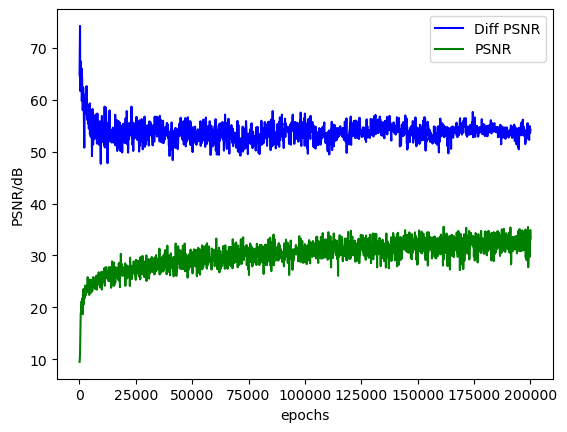

In [35]:
import numpy as np
import re
import matplotlib.pyplot as plt

logpath = 'log/lego_dif_psnrs.log'
diff_psnr_data = []
psnr_data = []
with open(logpath, 'r', encoding='UTF-8') as f:
    for line in f.readlines():
        matchObj = re.match(r'\[TRAIN\].*PSNR: (.+) difference psnr: tensor\(\[(.+)\]\)', line)
        if matchObj:
            psnr, diff_psnr = float(matchObj.group(1)), float(matchObj.group(2))
            diff_psnr_data.append(diff_psnr)
            psnr_data.append(psnr)

diff_psnr_data = np.asarray(diff_psnr_data)
psnr_data = np.asarray(psnr_data)


x = np.arange(100, psnr_data.shape[0] * 100 + 1, 100)
# print(x.shape)
fig, ax = plt.subplots()
ax.plot(x, diff_psnr_data, 'b', label="Diff PSNR")
ax.plot(x, psnr_data, 'g', label="PSNR")
ax.legend()
ax.set_ylabel('PSNR/dB')
ax.set_xlabel('epochs')
plt.show()


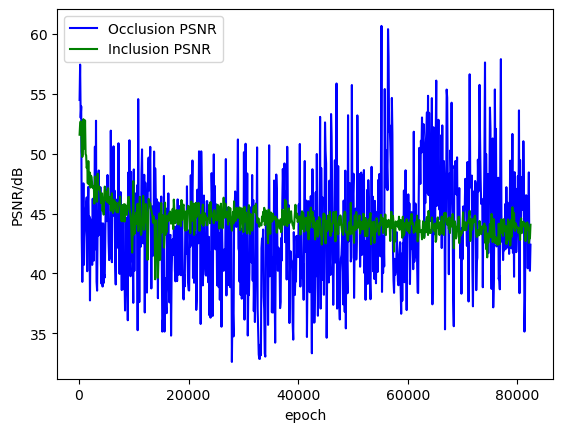

In [8]:
import numpy as np
import re
import matplotlib.pyplot as plt

example = '[TRAIN] Iter: 2800 Loss: 0.01550256460905075  inc PSNR: tensor([42.5903]) olc PSNR: tensor([44.7410])'

logpath = 'log/lego_inc_olc_psnr.log'
occ_psnr_data = []
inc_psnr_data = []
with open(logpath, 'r', encoding='UTF-8') as f:
    for line in f.readlines():
        matchObj = re.match(r'\[TRAIN\].*inc PSNR: tensor\(\[(.+)\]\) olc PSNR: tensor\(\[(.+)\]\)', line)
        if matchObj:
            occ_psnr, global_psnr = float(matchObj.group(1)), float(matchObj.group(2))
            occ_psnr_data.append(occ_psnr)
            inc_psnr_data.append(global_psnr)

occ_psnr_data = np.asarray(occ_psnr_data)
inc_psnr_data = np.asarray(inc_psnr_data)

x = np.arange(100, inc_psnr_data.shape[0] * 100 + 1, 100)
# print(x.shape)
fig, ax = plt.subplots()
ax.plot(x, occ_psnr_data, 'b', label="Occlusion PSNR")
ax.plot(x, inc_psnr_data, 'g', label="Inclusion PSNR")
ax.legend()
ax.set_ylabel('PSNR/dB')
ax.set_xlabel('epoch')
plt.show()

In [7]:
import numpy as np

path = 'results/lego/entropy/alpha_ent_map1000.npy'
x = np.load(path)
print(np.max(x))

0.99999744
